<a href="https://colab.research.google.com/github/Rahul-Biju-03/Audio-Emotion-Classifier/blob/main/COLAB_CNN_LSTM_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd

# Define the path where the CSV is saved
csv_path = '/content/drive/MyDrive/IIIT_FEATURES/features.csv'

# Load the CSV file into a DataFrame
features_df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
print(features_df.head())


          0         1         2         3         4         5         6  \
0  0.038154  0.454552  0.514377  0.526634  0.490737  0.355639  0.317084   
1  0.062052  0.401813  0.503195  0.546228  0.539514  0.504732  0.352745   
2  0.051986  0.401785  0.306156  0.349466  0.436649  0.491228  0.500970   
3  0.032536  0.463410  0.351489  0.303323  0.246813  0.250369  0.287914   
4  0.050765  0.511621  0.413723  0.370355  0.318719  0.318244  0.339921   

          7         8         9  ...       153           154           155  \
0  0.478529  0.590509  0.737484  ...  0.000001  2.802621e-07  1.055398e-07   
1  0.394625  0.536293  0.650543  ...  0.000402  4.220895e-04  3.920357e-04   
2  0.437722  0.281392  0.309678  ...  0.000020  2.759451e-05  1.414038e-05   
3  0.307294  0.413339  0.482591  ...  0.000005  4.073396e-06  3.617342e-06   
4  0.337482  0.427549  0.481702  ...  0.000204  2.074951e-04  2.175563e-04   

            156           157           158           159           160  \
0  7.

In [4]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
# Separate the features and labels
X = features_df.drop(columns=['labels']).values
Y = features_df['labels'].values

print("Features (X):")
print(X)
print("Labels (Y):")
print(Y)

Features (X):
[[3.81537543e-02 4.54551816e-01 5.14376998e-01 ... 5.22616830e-08
  3.35672183e-08 7.03993175e-09]
 [6.20524089e-02 4.01812948e-01 5.03195455e-01 ... 3.95108411e-04
  3.64938590e-04 3.52637336e-04]
 [5.19856771e-02 4.01785314e-01 3.06156188e-01 ... 2.65154483e-07
  6.59438442e-08 8.55960280e-09]
 ...
 [4.66308594e-02 2.77437598e-01 7.20867217e-01 ... 1.26330875e-07
  7.78374698e-08 2.01761612e-08]
 [4.82910156e-02 2.85160736e-01 7.37810464e-01 ... 1.30150782e-05
  1.07352976e-05 1.31981550e-05]
 [2.95410156e-02 1.73168018e-01 2.04349026e-01 ... 4.61673807e-07
  8.94364049e-08 1.25037944e-08]]
Labels (Y):
['mild' 'mild' 'mild' ... 'minimal' 'minimal' 'minimal']


In [6]:
Features = pd.DataFrame(X)
Features["labels"] = Y

In [7]:
X = Features.iloc[:, :-1].values
Y = Features["labels"].values
Y

array(['mild', 'mild', 'mild', ..., 'minimal', 'minimal', 'minimal'],
      dtype=object)

In [8]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12957, 162), (12957, 4), (4320, 162), (4320, 4))

In [10]:
scaler = StandardScaler() #normalisation
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12957, 162), (12957, 4), (4320, 162), (4320, 4))

In [11]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12957, 162, 1), (12957, 4), (4320, 162, 1), (4320, 4))

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
import numpy as np

def create_model():
    model = Sequential()
    # Convolutional Layers
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))  # Increased dropout rate

    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))  # Increased dropout rate

    model.add(Conv1D(256, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))  # Increased dropout rate

    # LSTM Layers
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.4))  # Increased dropout rate
    model.add(LSTM(64))

    # Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))  # Increased dropout rate
    model.add(Dense(len(encoder.categories_[0]), activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Define the base save directory
save_dir = '/content/drive/My Drive/IIIT_MODEL'

# Training multiple models and storing history
# Training multiple models and storing history
histories = []
models = []
for i in range(5):  # Train 5 models for ensemble
    model = create_model()
    history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_lr])
    models.append(model)
    histories.append(history.history)  # Store history

    # Save each model with a unique filename
    model_name = f'CNN-LSTM-Ensemble3-{i+1}.h5'
    model_path = f"{save_dir}/{model_name}"
    model.save(model_path)
    print(f"Model {i+1} saved to {model_path}")



Epoch 1/50
405/405 [==============================] - 18s 16ms/step - loss: 1.2566 - accuracy: 0.3977 - val_loss: 1.2480 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 2/50
405/405 [==============================] - 6s 16ms/step - loss: 1.2441 - accuracy: 0.4092 - val_loss: 1.2391 - val_accuracy: 0.4051 - lr: 0.0010
Epoch 3/50
405/405 [==============================] - 5s 13ms/step - loss: 1.2364 - accuracy: 0.4115 - val_loss: 1.2364 - val_accuracy: 0.4093 - lr: 0.0010
Epoch 4/50
405/405 [==============================] - 6s 14ms/step - loss: 1.2265 - accuracy: 0.4215 - val_loss: 1.2261 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 5/50
405/405 [==============================] - 6s 15ms/step - loss: 1.2170 - accuracy: 0.4214 - val_loss: 1.2165 - val_accuracy: 0.4197 - lr: 0.0010
Epoch 6/50
405/405 [==============================] - 5s 13ms/step - loss: 1.2085 - accuracy: 0.4310 - val_loss: 1.2140 - val_accuracy: 0.4097 - lr: 0.0010
Epoch 7/50
405/405 [==============================] - 7s 16ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 1 saved to /content/drive/My Drive/IIIT_MODEL/CNN-LSTM-Ensemble3-1.h5
Epoch 1/50
405/405 [==============================] - 13s 18ms/step - loss: 1.2557 - accuracy: 0.3928 - val_loss: 1.2470 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 2/50
405/405 [==============================] - 5s 13ms/step - loss: 1.2466 - accuracy: 0.4032 - val_loss: 1.2409 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 3/50
405/405 [==============================] - 7s 16ms/step - loss: 1.2340 - accuracy: 0.4111 - val_loss: 1.2318 - val_accuracy: 0.4037 - lr: 0.0010
Epoch 4/50
405/405 [==============================] - 5s 13ms/step - loss: 1.2242 - accuracy: 0.4187 - val_loss: 1.2238 - val_accuracy: 0.4215 - lr: 0.0010
Epoch 5/50
405/405 [==============================] - 6s 15ms/step - loss: 1.2098 - accuracy: 0.4279 - val_loss: 1.2133 - val_accuracy: 0.4324 - lr: 0.0010
Epoch 6/50
405/405 [==============================] - 8s 19ms/step - loss: 1.2000 - accuracy: 0.4364 - val_loss: 1.1940 - val_accuracy: 0.4521 

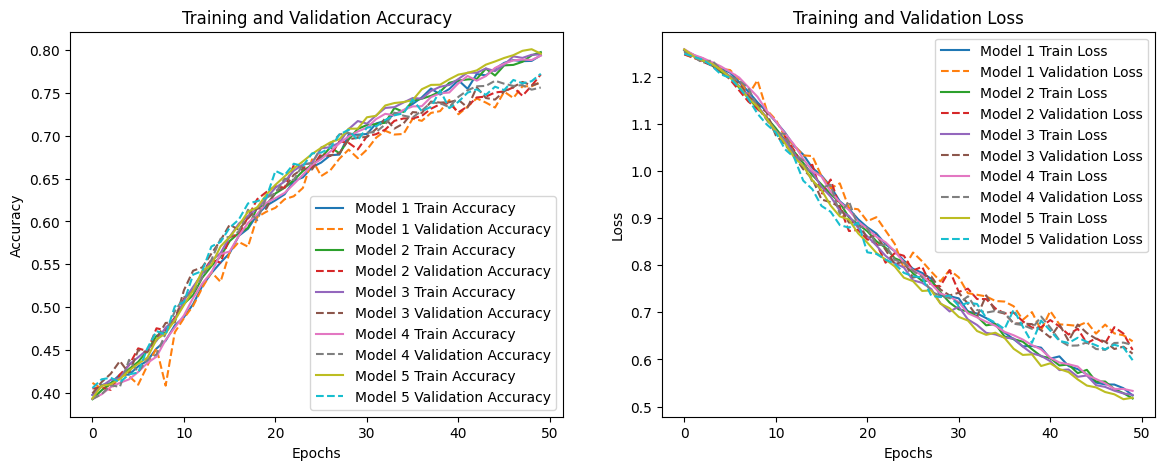

In [14]:
# Function to plot training and validation accuracy/loss
def plot_history(histories):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history['accuracy'], label=f'Model {i+1} Train Accuracy')
        plt.plot(history['val_accuracy'], label=f'Model {i+1} Validation Accuracy', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history['loss'], label=f'Model {i+1} Train Loss')
        plt.plot(history['val_loss'], label=f'Model {i+1} Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(histories)

In [15]:
# Function to average predictions
def ensemble_predict(models, x):
    predictions = [model.predict(x) for model in models]
    return np.mean(predictions, axis=0)

# Evaluate ensemble accuracy
ensemble_accuracy = np.mean(np.argmax(ensemble_predict(models, x_test), axis=1) == np.argmax(y_test, axis=1))
print("Ensemble Accuracy: ", ensemble_accuracy * 100, "%")

135/135 [==============================] - 1s 4ms/step
Ensemble Accuracy:  81.57407407407408 %


# **EVALUATING MODEL ON UNSEEN DATA**

In [17]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

# Reshape x_train and x_test to 2D
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_test_2d = x_test.reshape(x_test.shape[0], -1)

# Fit the scaler on the training data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_2d)
x_test_scaled = scaler.transform(x_test_2d)

# Reshape back to 3D after scaling
x_train = x_train_scaled.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test_scaled.reshape(x_test.shape[0], x_test.shape[1], 1)

# Save the fitted scaler
scaler_path = "/content/drive/MyDrive/IIIT_MODEL/scaler.pkl"
joblib.dump(scaler, scaler_path)


['/content/drive/MyDrive/IIIT_MODEL/scaler.pkl']

In [18]:
import joblib
import librosa
import numpy as np
from keras.models import load_model

# Load the saved scaler
scaler_path = "/content/drive/MyDrive/IIIT_MODEL/scaler.pkl"
scaler = joblib.load(scaler_path)

# Function to extract features from the audio data
def extract_features(data, sample_rate):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# Function to get features for the new audio sample
def get_features_for_sample(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))

    return result

# Function to add noise to the audio data
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

# Function to stretch the audio data
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Function to change the pitch of the audio data
def pitch(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor * 4)


In [19]:
# Path to the new audio sample
new_audio_sample_path = '/content/drive/MyDrive/IIIT_EVAL_DATA/C1.wav'

# Extract features for the new audio sample
new_sample_features = get_features_for_sample(new_audio_sample_path)

# Standardize the new sample features using the same scaler used for training data
new_sample_features_2d = new_sample_features.reshape(new_sample_features.shape[0], -1)
new_sample_features_scaled = scaler.transform(new_sample_features_2d)

# Reshape back to 3D after scaling
new_sample_features_scaled = new_sample_features_scaled.reshape(new_sample_features.shape[0], new_sample_features.shape[1], 1)


In [20]:
# Load the ensemble models
ensemble_models = []
for i in range(5):  # Assuming you have 5 models in the ensemble
    model_path = f'/content/drive/MyDrive/IIIT_MODEL/CNN-LSTM-Ensemble3-{i+1}.h5'
    model = load_model(model_path)
    ensemble_models.append(model)

# Predict the label for the new sample using each model in the ensemble
predictions = []
for model in ensemble_models:
    prediction = model.predict(new_sample_features_scaled)
    predictions.append(prediction)

# Aggregate predictions (e.g., by averaging the probabilities)
average_prediction = np.mean(predictions, axis=0)


1/1 [==============================] - 1s 962ms/step


1/1 [==============================] - 1s 970ms/step


In [24]:
print(encoder.categories_)

[array(['mild', 'minimal', 'moderate', 'moderately severe'], dtype=object)]


In [34]:
import numpy as np

# Assuming predictions_array has shape (n_models, n_samples, n_classes)
print("Shape of predictions_array:", predictions_array.shape)

# Average across the model predictions for each sample
average_prediction = np.mean(predictions_array, axis=0)
print("Shape of average_prediction after averaging:", average_prediction.shape)

# Process predictions for each sample
for sample_index in range(average_prediction.shape[0]):
    predicted_label_index = np.argmax(average_prediction[sample_index])

    # Create a one-hot encoded array for the predicted class
    one_hot_prediction = np.zeros((1, average_prediction.shape[1]))
    one_hot_prediction[0, predicted_label_index] = 1

    # Use the one-hot encoded array for inverse_transform
    predicted_label = encoder.inverse_transform(one_hot_prediction)

    # Output the predicted label
    print(f"The predicted emotion for audio sample {sample_index + 1} is: {predicted_label[0]}")

# audio sample 1 is Original audio
# audio sample 2 is Audio with added noise
# audio sample 3 is Audio that's been stretched and pitch-shifted

Shape of predictions_array: (5, 3, 4)
Shape of average_prediction after averaging: (3, 4)
The predicted emotion for audio sample 1 is: ['minimal']
The predicted emotion for audio sample 2 is: ['minimal']
The predicted emotion for audio sample 3 is: ['minimal']
